In [1]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices
using KrylovKit, IterTools, FFTW
using Dierckx

Random.seed!(123);

In [20]:
# important functions
include("localization3d.jl")


SL (generic function with 1 method)

In [3]:
#=
""" 
    respline(x, y, N)

Use a 2D parametric B-spline to interpolate the closed curve to N points

# Arguments
- `x`: vector of x-coordinates
- `y`: vector of y-coordinates
- `N`: number of desired output points

# Outputs
- a matrix of size 2 x N in [y, x] order containing the splined coordinates

"""
function respline(x, y, N)
    ps = ParametricSpline(vcat(y', x'); s=0.0)
    return evaluate(ps,  LinRange(0, 1, N))
end

""" Spline all curves to have the same number of points """
equalNclosedcurve(thpha, N) = map(thph -> (length(thph) == N) ? thph : hcat(thph[1,1]*ones(N), respline(thph[:,3], thph[:,2], N)'), thpha)
=#

# Generate a random 3D surface

For 3D interpolation, some simplifying assumptions have been made:
- the 3D surface has been supplied as a set of contours in z-direction
- these contours are in sorted order (easy to generalize this)
- each contour has the same number of points (if not, you have to spline the boundary and interpolate, which is not hard), and the same orientation

We will just stack a bunch of blobs.

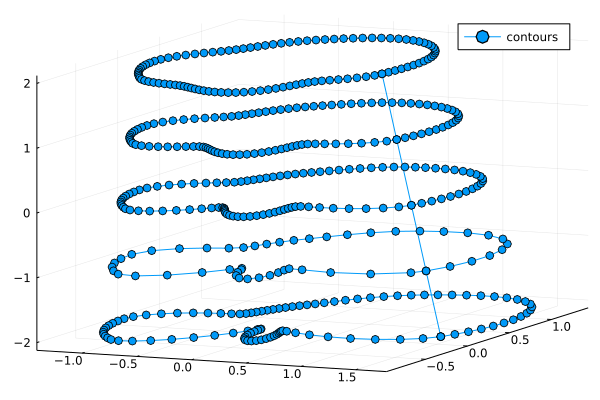

In [4]:
Nz = 5
x, y = blob(Nz,5)
N = 100

z = collect(-2:2)

Nx = length(x[1])
hcat(x[1], y[1])

# z, y, x is the order
thpha = map(i -> hcat(ones(length(y[i]))*z[i], y[i], x[i]), 1:Nz)

ind = vcat(collect(1:2:100), 100)

# Shorten the second closed curve
thpha[2] = hcat(thpha[2][ind, 1], thpha[2][ind, 2], thpha[2][ind, 3])

# println(size(thph))
thph = vcat(thpha...)
# This is necessary to close the curve
thph = vcat(thph, thph[1,:]')

p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", marker = :o)

In [5]:
thpha_new = equalNclosedcurve(thpha, N);

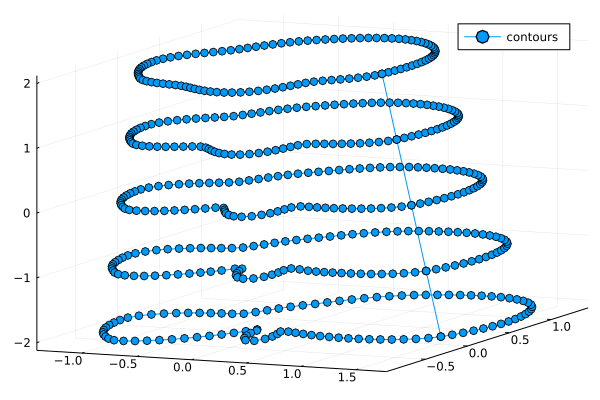

In [6]:
thph_new = vcat(thpha_new...)
p = plot(thph_new[:,3], thph_new[:,2], thph_new[:,1], label = "contours", marker = :o)

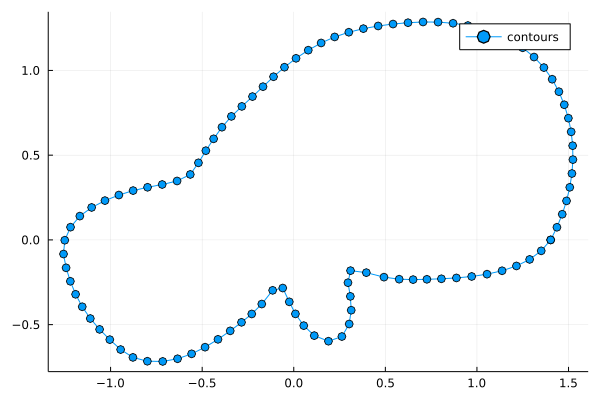

In [7]:
p = plot(thpha_new[2][:,3], thpha_new[2][:,2], label = "contours", marker = :o)

# Fill with quadrature nodes

## Get the quadrature nodes and scale to the range in z

In [8]:
Nqx = Nqy = 16
Nqz = 10

# set parameters for the integration

M  = 3
Kp = [4.0]
szs = int = (Nqx, Nqy, Nqz)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256

256

In [9]:
# compute the nodes - first scale in z
colf, th, wqz = scale_quad_nodez(Nqz, z)

([1, 1, 1, 2, 2, 3, 3, 4, 4, 4], [-1.9478130570343435, -1.730126733377969, -1.3588191365980489, -0.8667907882584944, -0.2977486779632624, 0.2977486779632624, 0.8667907882584944, 1.3588191365980489, 1.730126733377969, 1.9478130570343435], [0.06667134430868821, 0.14945134915058048, 0.21908636251598207, 0.2692667193099964, 0.2955242247147528, 0.2955242247147528, 0.2692667193099964, 0.21908636251598207, 0.14945134915058048, 0.06667134430868821])

In [10]:
newcurve, pkg = fill2d(z, colf, thpha_new, th, Nqx, Nqy)

(LinearAlgebra.Adjoint{Float64,Array{Float64,2}}[[-1.9478130570343435 -1.8571357020933626e-18 1.5298873847715704; -1.9478130570343435 0.08048338044964423 1.5713172669519886; … ; -1.9478130570343435 -0.06809234198369532 1.4692363169104925; -1.9478130570343435 -3.7471433776328374e-16 1.5298873847715704], [-1.730126733377969 -1.529360087096435e-18 1.5006552016664279; -1.730126733377969 0.07915106461445212 1.5403962662045698; … ; -1.730126733377969 -0.0672591891560565 1.4420579076156101; -1.730126733377969 -3.675545178689234e-16 1.5006552016664279], [-1.3588191365980489 -9.702731686197096e-19 1.4507938623085421; -1.3588191365980489 0.07687853328309519 1.487654310326452; … ; -1.3588191365980489 -0.06583808024583715 1.3956996905715588; -1.3588191365980489 -3.5534201193975646e-16 1.4507938623085423], [-0.8667907882584944 -1.7218790350215487e-19 1.3847214397052423; -0.8667907882584944 0.0740393029044811 1.4177893471921188; … ; -0.8667907882584944 -0.06420924925246566 1.3343746519824846; -0.866

In [11]:
# collate nodes weights
no, sqwt, ev = getnodeswts3d(szs, pkg, th, wqz)

([(-0.8888361133675675, -0.7317542351848196, -1.9478130570343435), (-0.8854315649710779, -0.7317542351848196, -1.9478130570343435), (-0.879435745887321, -0.7317542351848196, -1.9478130570343435), (-0.8710639707507069, -0.7317542351848196, -1.9478130570343435), (-0.8606186441523695, -0.7317542351848196, -1.9478130570343435), (-0.8484772449508914, -0.7317542351848196, -1.9478130570343435), (-0.8350785801388949, -0.7317542351848196, -1.9478130570343435), (-0.8209069057200165, -0.7317542351848196, -1.9478130570343435), (-0.8064744190545847, -0.7317542351848196, -1.9478130570343435), (-0.7923027446357063, -0.7317542351848196, -1.9478130570343435)  …  (0.21533682469431825, 1.1313177863124695, 1.9478130570343435), (0.23841859591022754, 1.1313177863124695, 1.9478130570343435), (0.26192515875112854, 1.1313177863124695, 1.9478130570343435), (0.28500692996703786, 1.1313177863124695, 1.9478130570343435), (0.3068296805219884, 1.1313177863124695, 1.9478130570343435), (0.3266046901874814, 1.131317786

In [21]:
# or you can do it all in one shot, without intermediates:
maxrank = 256
s, sl = slepian3(szs, z, thpha; 
                M = 3, Kp = [4.0], prec = 1e-8, exact = false, lvl = 6, 
                    maxrank = 256, int = nothing)

(Complex{Float64}[38.876016922528684 + 0.0im, 37.28815139902605 + 0.0im, 36.81007318613313 + 0.0im], Array{Complex{Float64},3}[[0.0016586474365349044 + 0.0im -0.0005737984856998054 + 0.0im … -0.008687453016290966 + 0.0im -0.00697214105955431 + 0.0im; -0.0043619016095543155 + 0.0im -0.008139585622101875 + 0.0im … -0.009363377851890628 + 0.0im -0.008376588148715634 + 0.0im; … ; -0.001900762500795665 + 0.0im -0.0025631954863124724 + 0.0im … 0.006651843660110467 + 0.0im 0.005794730179448992 + 0.0im; 0.0023194886517860355 + 0.0im 0.0017947864861732386 + 0.0im … 0.005141050626748215 + 0.0im 0.00360075197552504 + 0.0im]

[-0.010433801250730058 + 0.0im -0.018267916328766502 + 0.0im … -0.012054654812908981 + 0.0im -0.01323356142806402 + 0.0im; -0.029816759204981308 + 0.0im -0.041065958274203736 + 0.0im … -0.01081623479875056 + 0.0im -0.013528073759979756 + 0.0im; … ; -0.004556563308586631 + 0.0im -0.005722434603188965 + 0.0im … 0.006316627304541492 + 0.0im 0.005948317112969478 + 0.0im; 0.001380

# Sanity plot 1 - scaled quadratuer points in z

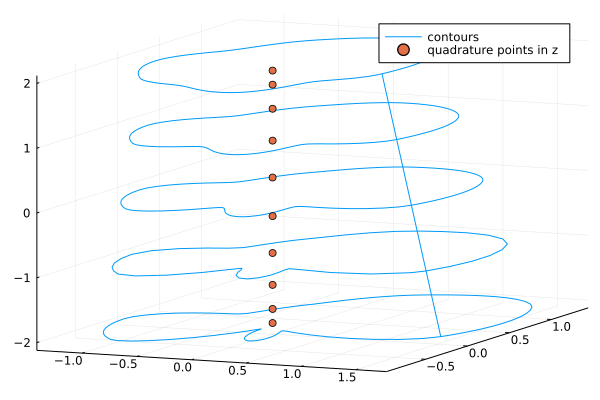

In [22]:
p1 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p1, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")

# Sanity plot II: Show the quadrature closed curves at each z level

Get the (x,y) values at each quadrature level z. 

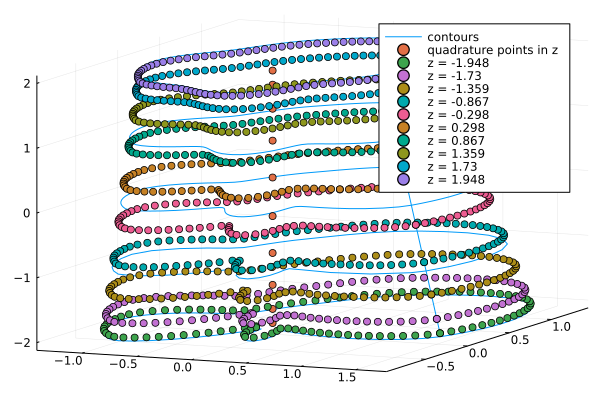

In [23]:
p2 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p2, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")
for i = 1:length(th)
    scatter!(p2, newcurve[i][:,3],newcurve[i][:,2],newcurve[i][:,1], label = "z = $(round(1000*th[i])/1000)")
end
p2

# Sanity plots III - IV: plot in 2D the quadrature nodes we are getting at each level.

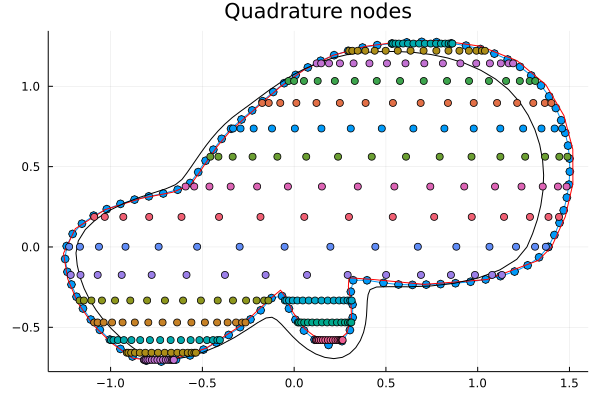

In [24]:
i = 4
N=100
q = plot(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")

plot!(q, thpha[colf[i]][:, 3], thpha[colf[i]][:,2], label = "z = $(thph[colf[i]][1,1])", c = :red)
plot!(q, thpha[colf[i]+1][:, 3], thpha[colf[i]+1][:,2], label = "z = $(thph[colf[i] + 1][1,1])", c = :black)


scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")


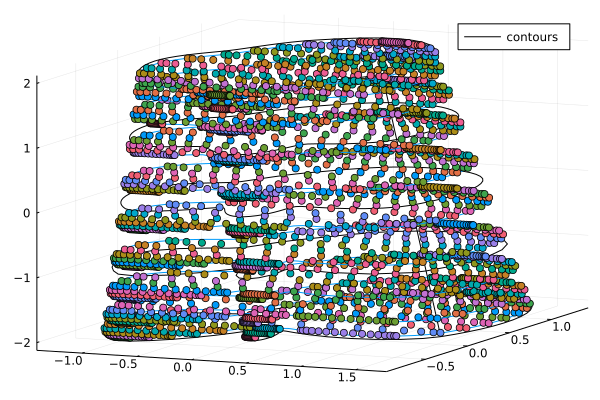

In [25]:
p3 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
for i = 1:10
    plot!(p3, newcurve[i][:,3], newcurve[i][:,2], ones(size(newcurve[i][:,2]))*th[i], c = 1, label = "")
    scatter!(p3, pkg[i][1], pkg[i][2], ones(Nqx,Nqy+1)*th[i] , label = "")
end
p3

# Sanity plot V - Show the sequences

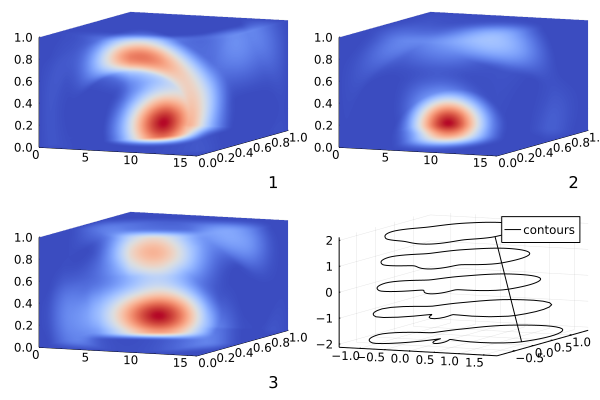

In [26]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ssl = SL(sl)
ran = 1:3
for i = ran
    p1[i] = heatmap( Float64.(sl[i]),
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    #plot!(p1[i], x[1], y[1], legend = false, c = :black)

    # ssl = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(ssl[i]), ylabel = i)
end

psimple = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
plot(p1[1:3]..., psimple)

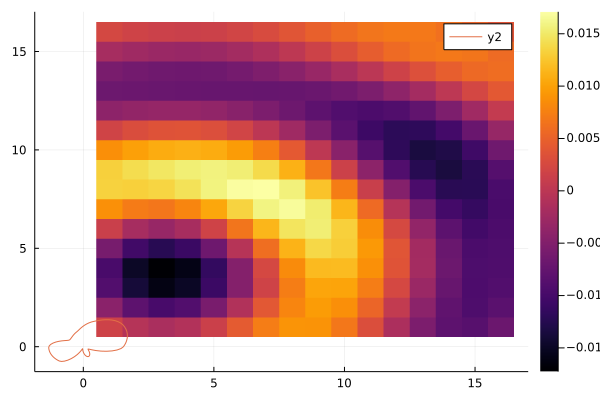

In [27]:
heatmap(Float64.(sl[1][:,:,1]))
plot!(thpha[1][:,3], thpha[1][:,2])

# Sanity plot VI: Show the FFTs

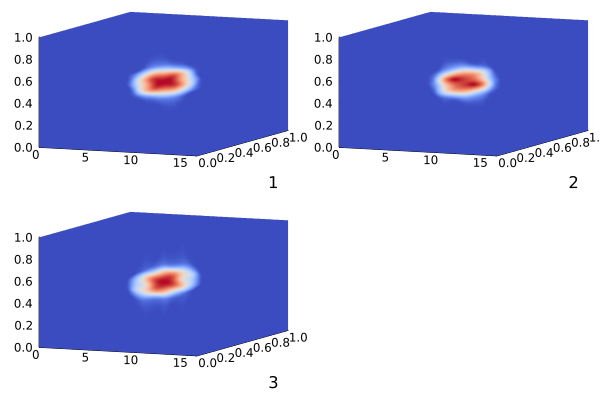

In [28]:
plot(p2[ran]...)